In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import itertools
matplotlib.use('Agg')
import mpld3
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import scipy.signal
import seaborn as sns

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [2]:
def get_power_spectral_density(timeseries, rate=1., nfft=4096, noverlap=None):
    """
    Returns the power spectral density of the given timeseries.

    Parameters
    ----------
    timeseries : ndarray
        One-dimensional timeseries for which we want the PSD.
    rate : float, optional
        Sampling rate of the data, in Hz. (or 1/whatever consistent with below)
    nfft : int, optional
        Window size for sampling power spectral density, in number of samples.
    noverlap : int, optional
        Number of points to overlap between segments. Defaults to nfft/2.

    Returns
    -------
    f : ndarray
        The frequency axis corresponding to Pxx.
    Pxx : ndarray
        The power spectral density of the given timeseries.
    """
    f, Pxx = scipy.signal.welch(
        timeseries,
        fs=rate,
        nperseg=nfft,
        noverlap=noverlap,
        window=np.hanning(nfft),
        detrend=lambda x: x,  # no detrending. detrend=False should also work
        scaling='density')
    return f, Pxx


def apply_high_pass_filter(timeseries, rate=1., cutoff_frequency=0.05):
    """
    Takes in a timeseries, and returns a timeseries with a 4th-order
    butterworth high-pass filter of the given cutoff frequency (in Hz) applied.
    Rate is the frequency of the incoming timeseries, in Hz.
    OR rate and cutoff_freq can be (1/whatever) as long as they are the same
    since they always appear as a ratio
    """
    b, a = scipy.signal.butter(N=4, Wn=cutoff_frequency/rate, btype='high')
    high_passed = scipy.signal.filtfilt(b=b, a=a, x=timeseries)
    initialization_error_cutoff = round(rate/cutoff_frequency)
    return high_passed[initialization_error_cutoff:]


In [124]:
le_dir='/home/disk/sipn/bitz/data/cesmLE/'
#le = xr.open_mfdataset(le_dir+'/*001.txt')
file1 = open(le_dir+"iceextent_nh_b.e11.B20TRC5CNBDRD.f09_g16.002.txt","r")
#tmp1=file1.readlines()
tmp1 = [float(line) for line in file1.readlines()] 
file1.close()

file2 = open(le_dir+"iceextent_nh_b.e11.BRCP85C5CNBDRD.f09_g16.002.txt","r")
#tmp2=file2.readlines()
tmp2 = [float(line) for line in file2.readlines()] 
file2.close()

le=tmp1+tmp2

dr = pd.date_range(start='1/1/1920', end='12/31/2080', freq='D')
dates = dr[(dr.day != 29) | (dr.month != 2)]

da_le= xr.DataArray(le, dims='time', coords={'time':dates})   
da_le.name = 'Extent'
da_le=da_le.sel(time=slice('1989-01-01','2018-12-31'))
le=da_le.to_dataset()

In [125]:
tmp=le.Extent.values
tmp1=tmp[4:]-tmp[0:10946]
dExt=np.zeros(10950)
dExt[2:10948]=tmp1
dExt=xr.DataArray(dExt, dims='time', coords={'time':le.time}) 
dExt.name = 'dExt'
le = xr.merge([le, dExt])

In [127]:
hcoff = 9.  # half cutoff window in days
rate=1.
cutoff_frequency=1./(2.*hcoff)
tlast=len(le.time)-9
tfirst = int(hcoff)

filtered=apply_high_pass_filter(le.Extent,rate, cutoff_frequency)
dfiltered=apply_high_pass_filter(le.dExt,rate, cutoff_frequency)

filtered=xr.DataArray(filtered, dims='time', coords={'time':le.time[tfirst:tlast]}) 
filtered.name = 'filtered'
le = xr.merge([le, filtered])

dfiltered=xr.DataArray(dfiltered, dims='time', coords={'time':le.time[tfirst:tlast]}) 
dfiltered.name = 'dfiltered'
le = xr.merge([le, dfiltered])
le

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<xarray.Dataset>
Dimensions:    (time: 10950)
Coordinates:
  * time       (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2018-12-31
Data variables:
    Extent     (time) float64 13.52 13.55 13.59 13.66 ... 13.05 13.11 13.17
    dExt       (time) float64 0.0 0.0 0.2144 0.1982 ... 0.332 0.2777 0.0 0.0
    filtered   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dfiltered  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan

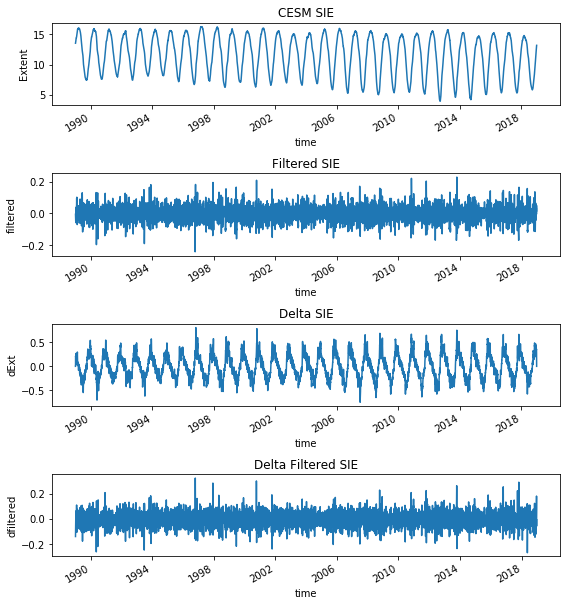

In [68]:
plt.figure(figsize=(8,10))
ax=plt.subplot(511)
le.Extent.plot()
plt.title('CESM SIE')
ax=plt.subplot(512)
le.filtered.plot()
plt.title('Filtered SIE')

ax=plt.subplot(513)
le.dExt.plot()
plt.title('Delta SIE')
ax=plt.subplot(514)
le.dfiltered.plot()
plt.title('Delta Filtered SIE')

plt.tight_layout(pad=1.0)


In [121]:
obs_dir='/home/disk/sipn/nicway/data/obs/NSIDC_0079/sipn_nc_yearly_agg'
ds_79 = xr.open_mfdataset(obs_dir+'/*.nc', concat_dim='time')
obs=ds_79.sel(nregions=99)
ds_79=None

In [122]:
years=pd.to_datetime(obs.time.values).year
obs.coords['years'] = xr.DataArray(years, dims='time', coords={'time':obs.time})   
# eliminate leap days
obs=obs.sel(time=~((obs.time.dt.month == 2) & (obs.time.dt.day == 29)))
NYRS=len(obs.time)/365.
doy = np.arange(1,366)
doy=np.resize(doy, 365*int(NYRS))
obs.coords['doy'] = xr.DataArray(doy, dims='time', coords={'time':obs.time})   

In [128]:
tmp=obs.Extent.values
tmp1=tmp[4:]-tmp[0:10946]
dExt=np.zeros(10950)
dExt[2:10948]=tmp1
dExt=xr.DataArray(dExt, dims='time', coords={'time':obs.time}) 
dExt.name = 'dExt'
obs = xr.merge([obs, dExt])

In [129]:
hcoff = 9.  # half cutoff window in days
rate=1.
cutoff_frequency=1./(2.*hcoff)
tlast=len(le.time)-9
tfirst = int(hcoff)


filtered=apply_high_pass_filter(obs.Extent,rate, cutoff_frequency)
dfiltered=apply_high_pass_filter(obs.dExt,rate, cutoff_frequency)

filtered=xr.DataArray(filtered, dims='time', coords={'time':obs.time[tfirst:tlast]}) 
filtered.name = 'filtered'
obs = xr.merge([obs, filtered])

dfiltered=xr.DataArray(dfiltered, dims='time', coords={'time':obs.time[tfirst:tlast]}) 
dfiltered.name = 'dfiltered'
obs = xr.merge([obs, dfiltered])
obs

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<xarray.Dataset>
Dimensions:       (time: 10950)
Coordinates:
  * time          (time) datetime64[ns] 1989-01-01 1989-01-02 ... 2018-12-31
    nregions      int64 99
    region_names  object 'panArctic'
    years         (time) int64 1989 1989 1989 1989 1989 ... 2018 2018 2018 2018
    doy           (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    Extent        (time) float64 dask.array<shape=(10950,), chunksize=(365,)>
    dExt          (time) float64 0.0 0.0 0.1301 0.1182 ... 0.3959 0.3897 0.0 0.0
    filtered      (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dfiltered     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan

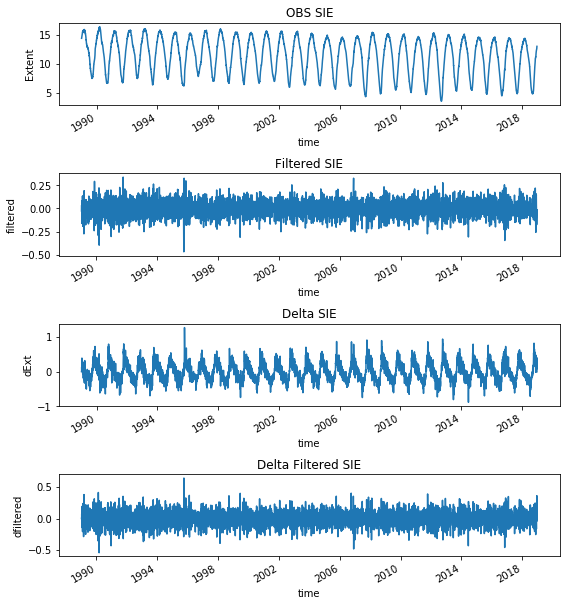

In [79]:
plt.figure(figsize=(8,10))
ax=plt.subplot(511)
obs.Extent.plot()
plt.title('OBS SIE')
ax=plt.subplot(512)
obs.filtered.plot()
plt.title('Filtered SIE')

ax=plt.subplot(513)
obs.dExt.plot()
plt.title('Delta SIE')
ax=plt.subplot(514)
obs.dfiltered.plot()
plt.title('Delta Filtered SIE')

plt.tight_layout(pad=1.0)

In [90]:
overlap=4096/4

O=get_power_spectral_density(obs.Extent, rate, nfft=overlap, noverlap=None)
Of=get_power_spectral_density(obs.filtered[tfirst:tlast], rate, nfft=overlap, noverlap=None)
Od=get_power_spectral_density(obs.dExt, rate, nfft=overlap, noverlap=None)
Odf=get_power_spectral_density(obs.dfiltered[tfirst:tlast], rate, nfft=overlap, noverlap=None)

M=get_power_spectral_density(le.Extent, rate, nfft=overlap, noverlap=None)
Mf=get_power_spectral_density(le.filtered[tfirst:tlast], rate, nfft=overlap, noverlap=None)
Md=get_power_spectral_density(le.dExt, rate, nfft=overlap, noverlap=None)
Mdf=get_power_spectral_density(le.dfiltered[tfirst:tlast], rate, nfft=overlap, noverlap=None)

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5,1,'filtered Delta SIE')

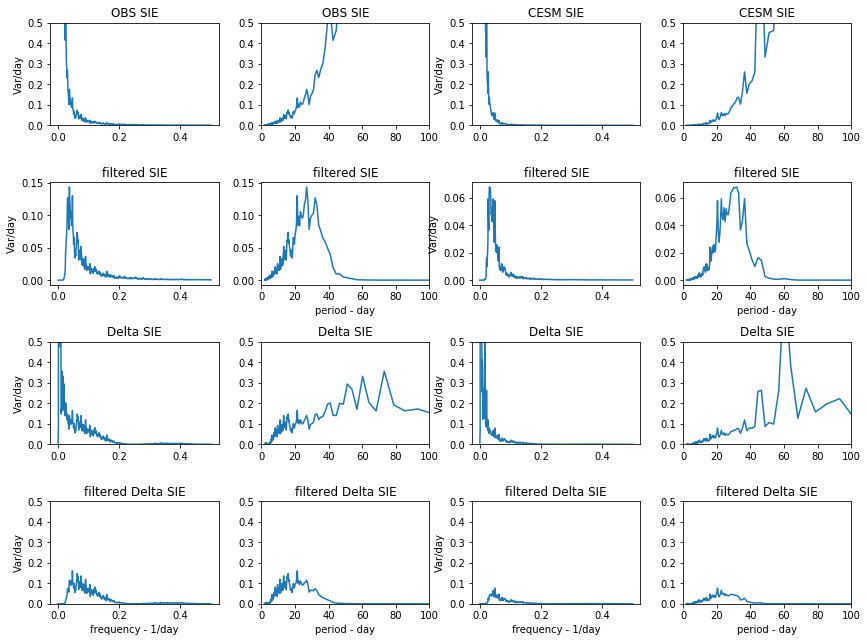

In [98]:
freq = O[0][:]
period = 1/freq # in days
period = np.flip(period)

plt.figure(figsize=(12,9))

ax=plt.subplot(441)
ax.plot(freq,O[1][:])
plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('OBS SIE')

ax=plt.subplot(445)
ax.plot(freq,Of[1][:])
#plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('filtered SIE')

ax=plt.subplot(442)
ax.plot(period,np.flip(O[1][:]))
plt.xlim([0, 100])
plt.ylim([0, 0.5])
plt.title('OBS SIE')

ax=plt.subplot(446)
ax.plot(period,np.flip(Of[1][:]))
plt.xlim([0, 100])
#plt.ylim([0, 0.5])
plt.xlabel('period - day')
plt.title('filtered SIE')

ax=plt.subplot(449)
ax.plot(freq,Od[1][:])
plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('Delta SIE')

ax=plt.subplot(4,4,13)
ax.plot(freq,Odf[1][:])
plt.ylim([0, 0.5])
plt.xlabel('frequency - 1/day')
plt.ylabel('Var/day')
plt.title('filtered Delta SIE')


ax=plt.subplot(4,4,10)
ax.plot(period,np.flip(Od[1][:]))
plt.xlim([0, 100])
plt.ylim([0, 0.5])
plt.title('Delta SIE')

ax=plt.subplot(4,4,14)
ax.plot(period,np.flip(Odf[1][:]))
plt.xlim([0, 100])
plt.ylim([0, 0.5])
plt.xlabel('period - day')
plt.title('filtered Delta SIE')

plt.tight_layout(pad=1.0)

ax=plt.subplot(443)
ax.plot(freq,M[1][:])
plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('CESM SIE')

ax=plt.subplot(447)
ax.plot(freq,Mf[1][:])
#plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('filtered SIE')

ax=plt.subplot(444)
ax.plot(period,np.flip(M[1][:]))
plt.xlim([0, 100])
plt.ylim([0, 0.5])
plt.title('CESM SIE')

ax=plt.subplot(448)
ax.plot(period,np.flip(Mf[1][:]))
plt.xlim([0, 100])
#plt.ylim([0, 0.5])
plt.xlabel('period - day')
plt.title('filtered SIE')

ax=plt.subplot(4,4,11)
ax.plot(freq,Md[1][:])
plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('Delta SIE')

ax=plt.subplot(4,4,15)
ax.plot(freq,Mdf[1][:])
plt.ylim([0, 0.5])
plt.xlabel('frequency - 1/day')
plt.ylabel('Var/day')
plt.title('filtered Delta SIE')


ax=plt.subplot(4,4,12)
ax.plot(period,np.flip(Md[1][:]))
plt.xlim([0, 100])
plt.ylim([0, 0.5])
plt.title('Delta SIE')

ax=plt.subplot(4,4,16)
ax.plot(period,np.flip(Mdf[1][:]))
plt.xlim([0, 100])
plt.ylim([0, 0.5])
plt.xlabel('period - day')
plt.title('filtered Delta SIE')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


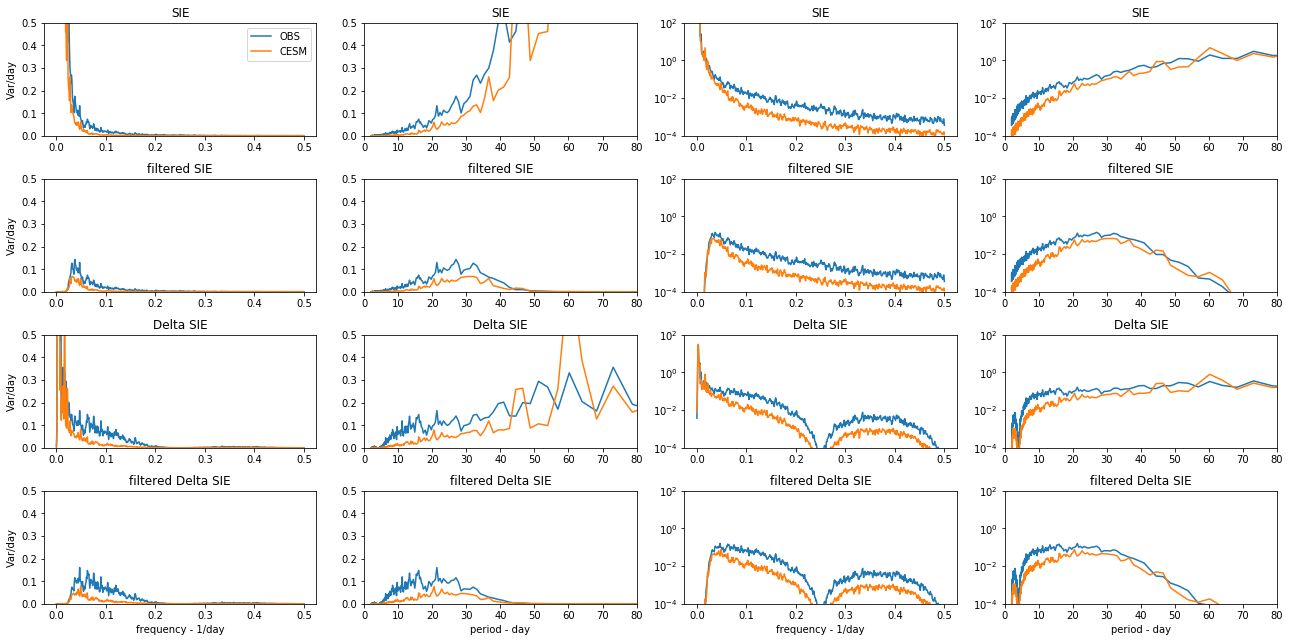

In [120]:

freq = O[0][:]
period = 1/freq # in days
period = np.flip(period)
maxper = 80

plt.figure(figsize=(18,9))

ax=plt.subplot(441)
ax.plot(freq,O[1][:],label='OBS')
ax.plot(freq,M[1][:],label='CESM')
ax.legend()
plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('SIE')

ax=plt.subplot(445)
ax.plot(freq,Of[1][:],freq,Mf[1][:])
plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('filtered SIE')

ax=plt.subplot(443)
ax.semilogy(freq,O[1][:],freq,M[1][:])
plt.ylim([0.0001, 100])
plt.title('SIE')

ax=plt.subplot(447)
ax.semilogy(freq,Of[1][:],freq,Mf[1][:])
plt.ylim([0.0001, 100])
plt.title('filtered SIE')


ax=plt.subplot(442)
ax.plot(period,np.flip(O[1][:]),period,np.flip(M[1][:]))
plt.xlim([0, maxper])
plt.ylim([0, 0.5])
plt.title('SIE')

ax=plt.subplot(446)
ax.plot(period,np.flip(Of[1][:]),period,np.flip(Mf[1][:]))
plt.xlim([0, maxper])
plt.ylim([0, 0.5])
plt.title('filtered SIE')

ax=plt.subplot(444)
ax.semilogy(period,np.flip(O[1][:]),period,np.flip(M[1][:]))
plt.xlim([0, maxper])
plt.ylim([0.0001, 100])
plt.title('SIE')

ax=plt.subplot(448)
ax.semilogy(period,np.flip(Of[1][:]),period,np.flip(Mf[1][:]))
plt.xlim([0, maxper])
plt.ylim([0.0001, 100])
plt.title('filtered SIE')

####################

ax=plt.subplot(449)
ax.plot(freq,Od[1][:],freq,Md[1][:])
plt.ylim([0, 0.5])
plt.ylabel('Var/day')
plt.title('Delta SIE')

ax=plt.subplot(4,4,13)
ax.plot(freq,Odf[1][:],freq,Mdf[1][:])
plt.ylim([0, 0.5])
plt.xlabel('frequency - 1/day')
plt.ylabel('Var/day')
plt.title('filtered Delta SIE')


ax=plt.subplot(4,4,11)
ax.semilogy(freq,Od[1][:],freq,Md[1][:])
plt.ylim([0.0001, 100])
plt.title('Delta SIE')

ax=plt.subplot(4,4,15)
ax.semilogy(freq,Odf[1][:],freq,Mdf[1][:])
plt.ylim([0.0001, 100])
plt.xlabel('frequency - 1/day')
plt.title('filtered Delta SIE')


ax=plt.subplot(4,4,10)
ax.plot(period,np.flip(Od[1][:]),period,np.flip(Md[1][:]))
plt.xlim([0, maxper])
plt.ylim([0, 0.5])
plt.title('Delta SIE')

ax=plt.subplot(4,4,14)
ax.plot(period,np.flip(Odf[1][:]),period,np.flip(Mdf[1][:]))
plt.xlim([0, maxper])
plt.ylim([0, 0.5])
plt.xlabel('period - day')
plt.title('filtered Delta SIE')

ax=plt.subplot(4,4,12)
ax.semilogy(period,np.flip(Od[1][:]),period,np.flip(Md[1][:]))
plt.xlim([0, maxper])
plt.ylim([0.0001, 100])
plt.title('Delta SIE')

ax=plt.subplot(4,4,16)
ax.semilogy(period,np.flip(Odf[1][:]),period,np.flip(Mdf[1][:]))
plt.xlim([0, maxper])
plt.ylim([0.0001, 100])
plt.xlabel('period - day')
plt.title('filtered Delta SIE')

plt.tight_layout(pad=1.0)

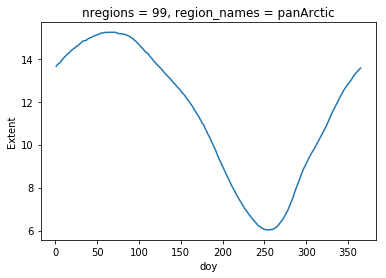

In [106]:
# fun to compute but not used
obsclimo=obs.Extent.groupby('doy').mean(dim='time')
obsclimo.plot()